# README
This notebook is used to split the dataset.

In [3]:
import numpy as np
import pickle
import pandas as pd
import numpy as np
import random
import os
import json
import matplotlib.pyplot as plt
random.seed(2024)
np.random.seed(2024)

# HUST dataset

In [4]:
# Here is the train_ids provided by BatteryML
data_path = '/data/trf/python_works/Battery-LLM/dataset/HUST'
tmp_files = os.listdir(data_path)
life_labels = json.load(open('/data/trf/python_works/Battery-LLM/dataset/HUST_labels.json'))
files = [i for i in tmp_files if i in life_labels]

test_ratio = 0.2
testing_set = random.sample(files, int(len(files)*0.2))
training_set = [i for i in files if i not in testing_set]

val_ratio = 0.2

validation_set= random.sample(training_set, int(len(training_set)*0.25))
training_set = [i for i in training_set if i not in validation_set]


assert len(training_set) + len(validation_set) + len(testing_set) == len(files)

print(f'training_set: {len(training_set)} {training_set}')
print(f'Val set: {len(validation_set)} {validation_set}')
print(f'Test set: {len(testing_set)} {testing_set}')

training_set: 47 ['HUST_10-1.pkl', 'HUST_1-6.pkl', 'HUST_8-7.pkl', 'HUST_9-5.pkl', 'HUST_7-8.pkl', 'HUST_7-4.pkl', 'HUST_10-3.pkl', 'HUST_10-6.pkl', 'HUST_9-4.pkl', 'HUST_8-4.pkl', 'HUST_7-2.pkl', 'HUST_5-2.pkl', 'HUST_2-7.pkl', 'HUST_1-8.pkl', 'HUST_4-8.pkl', 'HUST_7-7.pkl', 'HUST_7-5.pkl', 'HUST_9-3.pkl', 'HUST_10-7.pkl', 'HUST_10-2.pkl', 'HUST_8-8.pkl', 'HUST_3-2.pkl', 'HUST_8-2.pkl', 'HUST_9-2.pkl', 'HUST_8-6.pkl', 'HUST_9-6.pkl', 'HUST_1-4.pkl', 'HUST_4-3.pkl', 'HUST_4-6.pkl', 'HUST_4-1.pkl', 'HUST_7-6.pkl', 'HUST_1-7.pkl', 'HUST_6-5.pkl', 'HUST_7-3.pkl', 'HUST_10-8.pkl', 'HUST_6-2.pkl', 'HUST_6-8.pkl', 'HUST_9-8.pkl', 'HUST_5-1.pkl', 'HUST_8-1.pkl', 'HUST_3-1.pkl', 'HUST_4-2.pkl', 'HUST_2-2.pkl', 'HUST_5-5.pkl', 'HUST_2-6.pkl', 'HUST_10-4.pkl', 'HUST_9-7.pkl']
Val set: 15 ['HUST_1-3.pkl', 'HUST_2-8.pkl', 'HUST_10-5.pkl', 'HUST_1-5.pkl', 'HUST_5-3.pkl', 'HUST_8-5.pkl', 'HUST_6-6.pkl', 'HUST_9-1.pkl', 'HUST_4-4.pkl', 'HUST_2-4.pkl', 'HUST_3-4.pkl', 'HUST_5-4.pkl', 'HUST_1-1.pkl', '

In [10]:
def resample_charge_discharge_curves(voltages, currents, capacity_in_battery):
    '''
    resample the charge and discharge curves based on the natural records
    :param voltages:charge or dicharge voltages
    :param currents: charge or discharge current
    :param capacity_in_battery: remaining capacities in the battery
    :return:interploted records
    '''
    charge_discharge_len = 300
    charge_discharge_len = charge_discharge_len // 2
    raw_bases = np.arange(1, len(voltages)+1)
    interp_bases = np.linspace(1, len(voltages)+1, num=charge_discharge_len,
                                    endpoint=True)
    interp_voltages = np.interp(interp_bases, raw_bases, voltages)
    interp_currents = np.interp(interp_bases, raw_bases, currents)
    interp_capacity_in_battery = np.interp(interp_bases, raw_bases, capacity_in_battery)
    return interp_voltages, interp_currents, interp_capacity_in_battery

CALB


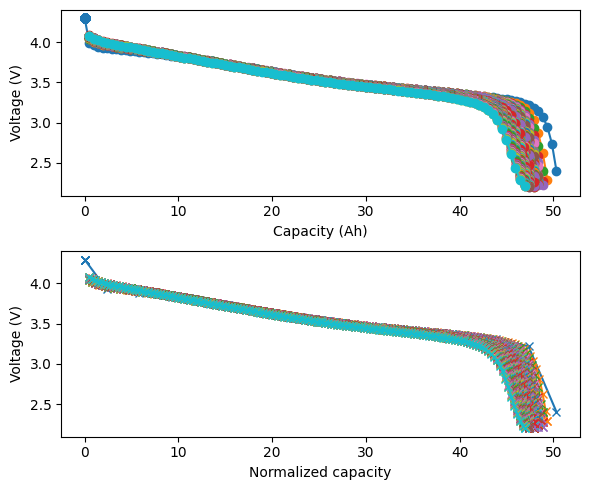

In [11]:
# data_path = '/data/trf/python_works/Battery-LLM/dataset/Tongji/Tongji1_CY25-05_1-#15.pkl'
data_path = '/data/trf/python_works/Battery-LLM/dataset/CALB/CALB_0_B189.pkl'
data = pickle.load(open(data_path, 'rb'))
is_discharge = True
#data = pickle.load(open('../dataset/HUST/HUST_7-5.pkl', 'rb'))
cycle_data = data['cycle_data']
nominal_capacity = data['nominal_capacity_in_Ah']
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
prefix = data_path.split('/')[-1]
prefix = prefix.split('_')[0]
print(prefix)
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,5))
for correct_cycle_index, sub_cycle_data in enumerate(cycle_data[:100]):
    cycle_df = pd.DataFrame()
    for key in need_keys:
        cycle_df[key] = sub_cycle_data[key]    
    cycle_df['cycle_number'] = correct_cycle_index + 1
    cycle_df['cycle_number'] = correct_cycle_index + 1
    cycle_df.loc[cycle_df['charge_capacity_in_Ah']<0] = np.nan
    cycle_df.bfill(inplace=True) # deal with NaN
    voltage_records = cycle_df['voltage_in_V'].values
    current_records = cycle_df['current_in_A'].values
    current_records_in_C = current_records/nominal_capacity
    charge_capacity_records = cycle_df['charge_capacity_in_Ah'].values
    discharge_capacity_records = cycle_df['discharge_capacity_in_Ah'].values

    cutoff_voltage_indices = np.nonzero(current_records_in_C>=0.01) # This includes constant-voltage charge data, 49th cycle of MATR_b1c18 has some abnormal voltage records
    charge_end_index = cutoff_voltage_indices[0][-1] # after charge_end_index, there are rest after charge, discharge, and rest after discharge data

    cutoff_voltage_indices = np.nonzero(current_records_in_C<=-0.01) 
    discharge_end_index = cutoff_voltage_indices[0][-1]
    
    # tmp_discharge_capacity_records = max(charge_capacity_records) - discharge_capacity_records
    if prefix in ['RWTH', 'OX', 'ZN-coin', 'CALB']:
        # Every cycle first discharge and then charge
        #capacity_in_battery = np.where(charge_capacity_records==0, discharge_capacity_records, charge_capacity_records)
        discharge_voltages = voltage_records[:discharge_end_index]
        discharge_capacities = discharge_capacity_records[:discharge_end_index]
        discharge_currents = current_records[:discharge_end_index]
        
        charge_voltages = voltage_records[discharge_end_index:]
        charge_capacities = charge_capacity_records[discharge_end_index:]
        charge_currents = current_records[discharge_end_index:]
        charge_current_in_C = charge_currents / nominal_capacity
        
        charge_voltages = charge_voltages[np.abs(charge_current_in_C)>0.01]
        charge_capacities = charge_capacities[np.abs(charge_current_in_C)>0.01]
        charge_currents = charge_currents[np.abs(charge_current_in_C)>0.01]
    else:
        # Every cycle first charge and then discharge
        #capacity_in_battery = np.where(np.logical_and(current_records>=-(nominal_capacity*0.01), discharge_capacity_records<=nominal_capacity*0.01), charge_capacity_records, discharge_capacity_records)
        discharge_voltages = voltage_records[charge_end_index:]
        discharge_capacities = discharge_capacity_records[charge_end_index:]
        discharge_currents = current_records[charge_end_index:]
        discharge_current_in_C = discharge_currents / nominal_capacity
        
        discharge_voltages = discharge_voltages[np.abs(discharge_current_in_C)>0.01]
        discharge_capacities = discharge_capacities[np.abs(discharge_current_in_C)>0.01]
        discharge_currents = discharge_currents[np.abs(discharge_current_in_C)>0.01]
        
        charge_voltages = voltage_records[:charge_end_index]
        charge_capacities = charge_capacity_records[:charge_end_index]
        charge_currents = current_records[:charge_end_index]

    if is_discharge:
        ax1.plot(discharge_capacities, discharge_voltages, marker='o')
        discharge_voltages, discharge_currents, discharge_capacities = resample_charge_discharge_curves(discharge_voltages, discharge_currents,
                                                                                    discharge_capacities)
        ax2.plot(discharge_capacities, discharge_voltages, marker='x')
    else:
        ax1.plot(charge_capacities, charge_voltages, marker='o')
        charge_voltages, charge_currents, charge_capacities = resample_charge_discharge_curves(charge_voltages, charge_currents, charge_capacities)
        ax2.plot(charge_capacities, charge_voltages, marker='x')
    # plt.plot(current_records, marker='o', label='current')
    # plt.plot(cycle_df['charge_capacity_in_Ah'].values, marker='o', label='charge Q')
    # plt.plot(cycle_df['discharge_capacity_in_Ah'].values, marker='o', label='discharge Q')


ax2.set_xlabel('Normalized capacity')
ax2.set_ylabel('Voltage (V)')
ax1.set_xlabel('Capacity (Ah)')
ax1.set_ylabel('Voltage (V)')
fig.tight_layout()
plt.subplots_adjust(wspace =0, hspace =0.3)#调整子图间距
plt.show()